In [1]:
from __future__ import division
import numpy as np
import pandas as pd
from scipy.signal import hamming
from srmrpy.hilbert import hilbert
from srmrpy.modulation_filters import *
from gammatone.fftweight import fft_gtgram
from gammatone.filters import centre_freqs, make_erb_filters, erb_filterbank
from srmrpy.segmentaxis import segment_axis
from scipy.io.wavfile import read as readwav
import soundfile as sf
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def calc_erbs(low_freq, fs, n_filters):
    ear_q = 9.26449 # Glasberg and Moore Parameters
    min_bw = 24.7
    order = 1

    erbs = ((centre_freqs(fs, n_filters, low_freq)/ear_q)**order + min_bw**order)**(1/order)
    return erbs

def calc_cutoffs(cfs, fs, q):
    # Calculates cutoff frequencies (3 dB) for 2nd order bandpass
    w0 = 2*np.pi*cfs/fs
    B0 = np.tan(w0/2)/q
    L = cfs - (B0 * fs / (2*np.pi))
    R = cfs + (B0 * fs / (2*np.pi))
    return L, R

def normalize_energy(energy, drange=30.0):
    peak_energy = np.max(np.mean(energy, axis=0))
    min_energy = peak_energy*10.0**(-drange/10.0)
    energy[energy < min_energy] = min_energy
    energy[energy > peak_energy] = peak_energy
    return energy

def srmr(x, fs, n_cochlear_filters=23, low_freq=125, min_cf=4, max_cf=128, fast=True, norm=False):
    wLengthS = .256
    wIncS = .064
    # Computing gammatone envelopes
    if fast:
        mfs = 400.0
        gt_env = fft_gtgram(x, fs, 0.010, 0.0025, n_cochlear_filters, low_freq)
    else:
        cfs = centre_freqs(fs, n_cochlear_filters, low_freq)
        fcoefs = make_erb_filters(fs, cfs)
        gt_env = np.abs(hilbert(erb_filterbank(x, fcoefs)))
        mfs = fs

    wLength = int(np.ceil(wLengthS*mfs))
    wInc = int(np.ceil(wIncS*mfs))

    # Computing modulation filterbank with Q = 2 and 8 channels
    mod_filter_cfs = compute_modulation_cfs(min_cf, max_cf, 8)
    MF = modulation_filterbank(mod_filter_cfs, mfs, 2)

    n_frames = int(1 + (gt_env.shape[1] - wLength)//wInc)
    w = hamming(wLength+1)[:-1] # window is periodic, not symmetric

    energy = np.zeros((n_cochlear_filters, 8, n_frames))
    for i, ac_ch in enumerate(gt_env):
        mod_out = modfilt(MF, ac_ch)
        for j, mod_ch in enumerate(mod_out):
            mod_out_frame = segment_axis(mod_ch, wLength, overlap=wLength-wInc, end='pad')
            energy[i,j,:] = np.sum((w*mod_out_frame[:n_frames])**2, axis=1)

    if norm:
        energy = normalize_energy(energy)

    erbs = np.flipud(calc_erbs(low_freq, fs, n_cochlear_filters))

    avg_energy = np.mean(energy, axis=2)
    total_energy = np.sum(avg_energy)

    AC_energy = np.sum(avg_energy, axis=1)
    AC_perc = AC_energy*100/total_energy

    AC_perc_cumsum=np.cumsum(np.flipud(AC_perc))
    K90perc_idx = np.where(AC_perc_cumsum>90)[0][0]

    BW = erbs[K90perc_idx]

    cutoffs = calc_cutoffs(mod_filter_cfs, fs, 2)[0]

    if (BW > cutoffs[4]) and (BW < cutoffs[5]):
        Kstar=5
    elif (BW > cutoffs[5]) and (BW < cutoffs[6]):
        Kstar=6
    elif (BW > cutoffs[6]) and (BW < cutoffs[7]):
        Kstar=7
    elif (BW > cutoffs[7]):
        Kstar=8

    return np.sum(avg_energy[:, :4])/np.sum(avg_energy[:, 4:Kstar]), energy

def read_audio_file(filename):
    # Use soundfile to read the .flac audio file
    audio_data, fs = sf.read(filename, always_2d=True, dtype='float32')
    # Normalize the audio data to the range [-1, 1]
    audio_data /= np.max(np.abs(audio_data))
    return fs, audio_data

def process_file(f, n_cochlear_filters=23, low_freq=125, min_cf=4, max_cf=128, fast=True, norm=True):
    fs, s = read_audio_file(f)  # Use read_audio_file to handle .flac files
    if len(s.shape) > 1:
        s = s[:, 0]
    r, energy = srmr(s, fs, n_cochlear_filters=n_cochlear_filters,
                     min_cf=min_cf,
                     max_cf=max_cf,
                     fast=fast,
                     norm=norm)
    return energy, r

In [4]:
BASE_PATH = '/home/sspowar/scratch/archive/LA/LA'

In [5]:
# TRAIN

train_df = pd.read_csv(f'{BASE_PATH}/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt',
                       sep=" ", header=None)
train_df.columns =['speaker_id','filename','system_id','type','class_name']
# train_df.drop(columns=['null'],inplace=True)
train_df['filepath'] = f'{BASE_PATH}/ASVspoof2019_LA_train/flac/'+train_df.filename+'.flac'
train_df['target'] = (train_df.class_name=='spoof').astype('int32') # set labels 1 for fake and 0 for real
# if DEBUG:
#     train_df = train_df.groupby(['target']).sample(2500).reset_index(drop=True)
print(f'Train Samples: {len(train_df)}')

Train Samples: 25380


In [6]:
train_df.head()

,speaker_id,filename,system_id,type,class_name,filepath,target
0,LA_0079,LA_T_1138215,-,-,bonafide,/home/sspowar/scratch/archive/LA/LA/ASVspoof20...,0
1,LA_0079,LA_T_1271820,-,-,bonafide,/home/sspowar/scratch/archive/LA/LA/ASVspoof20...,0
2,LA_0079,LA_T_1272637,-,-,bonafide,/home/sspowar/scratch/archive/LA/LA/ASVspoof20...,0
3,LA_0079,LA_T_1276960,-,-,bonafide,/home/sspowar/scratch/archive/LA/LA/ASVspoof20...,0
4,LA_0079,LA_T_1341447,-,-,bonafide,/home/sspowar/scratch/archive/LA/LA/ASVspoof20...,0


In [7]:
# Separate real and fake recordings
real_recordings = train_df[train_df['target'] == 0]['filepath'].tolist()
fake_recordings = train_df[train_df['target'] == 1]['filepath'].tolist()


In [28]:
real_recordings = train_df[train_df['class_name'] == 'bonafide']['filepath'].tolist()

spoof_recordings_A01 = train_df[train_df['class_name'] == 'spoof']['filepath'][train_df['type'] == 'A01'].tolist()
spoof_recordings_A02 = train_df[train_df['class_name'] == 'spoof']['filepath'][train_df['type'] == 'A02'].tolist()
spoof_recordings_A03 = train_df[train_df['class_name'] == 'spoof']['filepath'][train_df['type'] == 'A03'].tolist()
spoof_recordings_A04 = train_df[train_df['class_name'] == 'spoof']['filepath'][train_df['type'] == 'A04'].tolist()
spoof_recordings_A05 = train_df[train_df['class_name'] == 'spoof']['filepath'][train_df['type'] == 'A05'].tolist()
spoof_recordings_A06 = train_df[train_df['class_name'] == 'spoof']['filepath'][train_df['type'] == 'A06'].tolist()


In [9]:
all_recordings = train_df['filepath'].tolist()
len(all_recordings)

25380

In [29]:
print(len(spoof_recordings_A01),
len(spoof_recordings_A02),
len(spoof_recordings_A03),
len(spoof_recordings_A04),
len(spoof_recordings_A05),
len(spoof_recordings_A06))
print(len(real_recordings))

3800 3800 3800 3800 3800 3800
2580


In [10]:
def plot_srmr(average_energy_real, average_energy_fake, save_path=None):
    # Calculate the maximum value of energy among both real and fake recordings
    max_energy = max(np.max(average_energy_real), np.max(average_energy_fake))

    # Plot the average energy for each cochlear filter and frame for both real and fake recordings
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.title('Average SRMR for Real Recordings')
    sns.heatmap(average_energy_real.T, cmap='viridis', xticklabels=10, yticklabels=10, vmax=max_energy)
    plt.xlabel('Cochlear Filters')
    plt.ylabel('Frames')

    plt.subplot(1, 2, 2)
    plt.title('Average SRMR for Fake Recordings')
    sns.heatmap(average_energy_fake.T, cmap='viridis', xticklabels=10, yticklabels=10, vmax=max_energy)
    plt.xlabel('Cochlear Filters')
    plt.ylabel('Frames')
    plt.tight_layout()

    if save_path is not None:
        plt.savefig(save_path)

    plt.show()


def calculate_average_srmr(recordings):
    total_energy = None
    n_recordings = len(recordings)
    
    for recording in tqdm(recordings, desc="Calculating SRMR", unit="file", leave=False):
        energy, r = process_file(recording)
        
        # Average along the time axis (axis 2) for each recording
        avg_energy = np.mean(energy, axis=2)
        
        # Sum up the average energy for each recording
        if total_energy is None:
            total_energy = avg_energy
        else:
            total_energy += avg_energy

    # Calculate the average energy across all recordings
    average_energy = total_energy / n_recordings
    return average_energy

In [30]:
average_real_energy = calculate_average_srmr(real_recordings)

print(average_real_energy.shape)
print(len(average_real_energy))


(23, 8)
23


In [31]:
np.save('average_real_energy.npy', average_real_energy)
# loaded_average_real_energy = np.load('average_real_energy.npy')

In [32]:
average_A01_energy = calculate_average_srmr(spoof_recordings_A01)
print(average_A01_energy.shape)
print(len(average_A01_energy))

(23, 8)
23


In [33]:
np.save('average_A01_energy.npy', average_A01_energy)

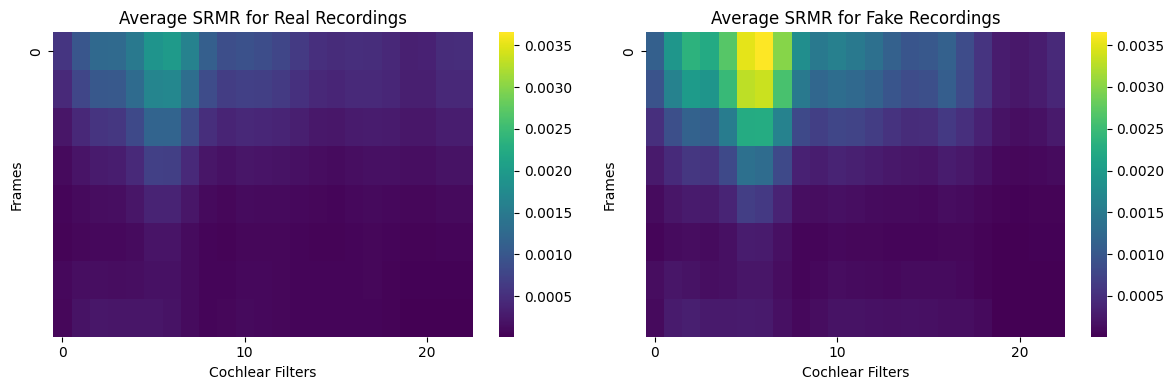

In [34]:
plot_srmr(average_real_energy, average_A01_energy, save_path='average_srmr_plot.png')

In [35]:
average_A02_energy = calculate_average_srmr(spoof_recordings_A02)
np.save('average_A02_energy.npy', average_A02_energy)

In [36]:
average_A03_energy = calculate_average_srmr(spoof_recordings_A03)
np.save('average_A03_energy.npy', average_A03_energy)

In [37]:
average_A04_energy = calculate_average_srmr(spoof_recordings_A04)
np.save('average_A04_energy.npy', average_A04_energy)

In [38]:
average_A05_energy = calculate_average_srmr(spoof_recordings_A05)
np.save('average_A05_energy.npy', average_A05_energy)

In [39]:
average_A06_energy = calculate_average_srmr(spoof_recordings_A06)
np.save('average_A06_energy.npy', average_A06_energy)

In [41]:
def plot_srmr(average_energies, save_path=None):
    # Calculate the maximum value of energy among all recordings
    max_energy = np.max([np.max(energy) for energy in average_energies])

    # Plot the average energy for each cochlear filter and frame for each recording type
    n_recordings = len(average_energies)
    plt.figure(figsize=(5 * n_recordings, 4))
    for i, energy in enumerate(average_energies):
        plt.subplot(1, n_recordings, i + 1)
        plt.title(f'Average SRMR for {"Real Recordings" if i == 0 else f"Fake Spoof {i}"}')
        sns.heatmap(energy.T, cmap='viridis', xticklabels=10, yticklabels=10, vmax=max_energy)
        plt.xlabel('Cochlear Filters')
        plt.ylabel('Frames')

    plt.tight_layout()

    if save_path is not None:
        plt.savefig(save_path)

    plt.show()

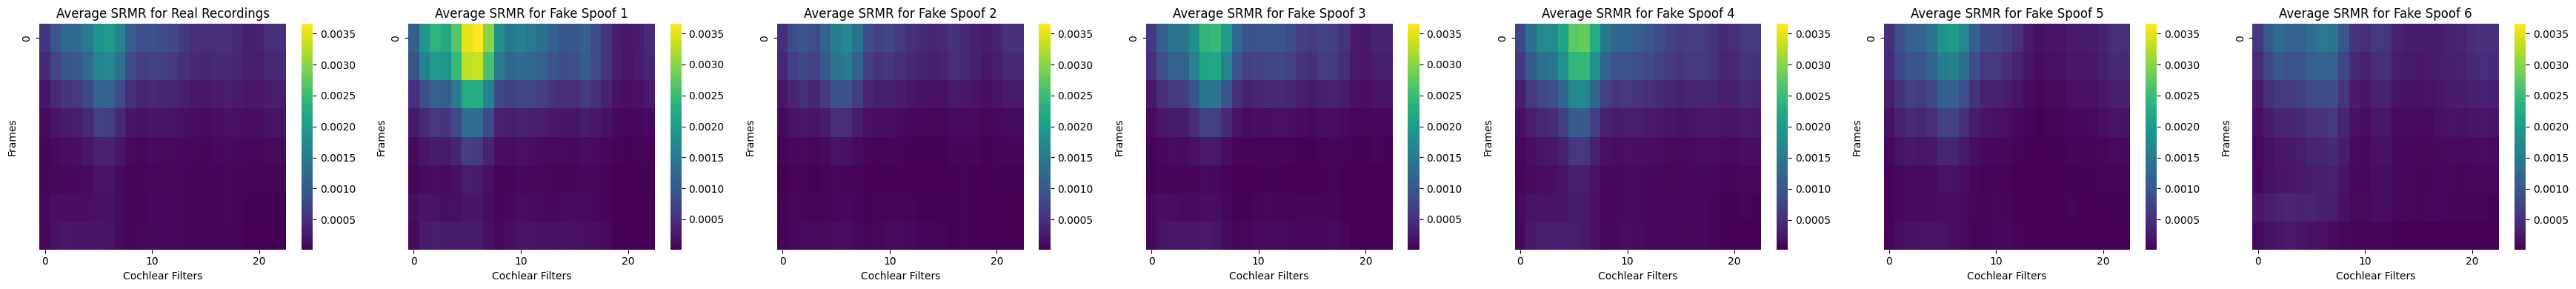

In [42]:
average_energies = [average_real_energy, average_A01_energy, average_A02_energy, average_A03_energy, average_A04_energy, average_A05_energy, average_A06_energy]
plot_srmr(average_energies, save_path='all_energies_plot.png')